※ DACON 동서발전 태양광 발전량 예측 AI 경진대회
https://dacon.io/competitions/official/235720/codeshare/2488?page=1&dtype=recent

In [2]:
import os
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib as plt
import seaborn as sns

In [3]:
path = '동서발전_data/'

In [4]:
files = sorted(glob(path + '*.csv'))

In [5]:
files

['동서발전_data/dangjin_fcst_data.csv',
 '동서발전_data/dangjin_obs_data.csv',
 '동서발전_data/energy.csv',
 '동서발전_data/sample_submission.csv',
 '동서발전_data/site_info.csv',
 '동서발전_data/ulsan_fcst_data.csv',
 '동서발전_data/ulsan_obs_data.csv']

# Data 적재

In [6]:
dangjin_fcst_data = pd.read_csv(files[0]) #당진지역 발전소 동네 예보
dangjin_obs_data = pd.read_csv(files[1]) #당진지역 발전소 인근 기상 관측 자료
ulsan_fcst_data = pd.read_csv(files[5]) #울산지역 발전소 동네 예보
ulsan_obs_data = pd.read_csv(files[6]) #울산지역 발전소 인근 기상 관측 자료
site_info = pd.read_csv(files[4]) #발전소 정보
energy = pd.read_csv(files[2]) #발전소별 발전량
sample_submission = pd.read_csv(files[3]) #예측한 발전량 제출 양식



# Data 확인

## site_info.csv - 발전소 정보

- Id : 사이트 식별자
- Capacity : 발전소 발전용량(MW)
- Address : 주소
- InstallationAngle : 설치각(º)
- IncidentAngle : 입사각(º)
- Latitude : 위도
- Longitude : 경도

In [7]:
site_info #발전소 정보

,Id,Capacity,Address,InstallationAngle,IncidentAngle,Latitude,Longitude
0,당진수상태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
1,당진자재창고태양광,0.7,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
2,당진태양광,1.0,충남 당진시 석문면 교로길 30,30.0,30.0,37.050753,126.510299
3,울산태양광,0.5,울산광역시 남구 용잠로 623,20.0,20.0,35.477651,129.380778


## energy.csv - 발전소별 발전량

- time : 1시간 단위 계량된 시간 (ex-2018-03-01 1:00:00 => 2018-03-01 00:00:00 ~ 2018-03-01 1:00:00 1시간동안 발전량 계량)
- dangjin_floating : 당진수상태양광 발전량(KW)
- dangjin_warehouse : 당진자재창고태양광 발전량(KW)
- dangjin : 당진태양광 발전량(KW)
- ulsan : 울산태양광 발전량(KW)

In [8]:
energy.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0


## 지역 발전소 인근 기상 관측 자료

- 지점 : 지점 코드
- 지점명 : 관측소 지점
- 일시 : 관측 시간
- 기온(°C) : 기온(°C)
- 풍속(m/s) : 풍속(m/s)
- 풍향(16방위) : 풍향(º)
- 습도(%) : 습도(%)
- 전운량(10분위) : 전운량(낮을 수록 구름이 적음)

In [9]:
dangjin_obs_data.head()

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
0,129,서산,2018-03-01 00:00,3.1,3.6,340.0,96.0,NaN
1,129,서산,2018-03-01 01:00,2.8,0.7,140.0,97.0,NaN
2,129,서산,2018-03-01 02:00,2.6,3.2,320.0,95.0,NaN
3,129,서산,2018-03-01 03:00,2.0,1.9,230.0,97.0,NaN
4,129,서산,2018-03-01 04:00,2.2,2.1,180.0,97.0,NaN


In [10]:
ulsan_obs_data.head()

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
0,152,울산,2018-03-01 00:00,8.2,3.9,340.0,98.0,10.0
1,152,울산,2018-03-01 01:00,7.0,4.1,320.0,97.0,10.0
2,152,울산,2018-03-01 02:00,6.5,5.9,290.0,80.0,NaN
3,152,울산,2018-03-01 03:00,6.2,4.6,320.0,79.0,3.0
4,152,울산,2018-03-01 04:00,6.7,4.5,320.0,73.0,1.0


## 지역 발전소 동네 예보
 - Forecast time : 예보 발표 시점
 - forecast : 예보 시간 (ex - Forecast time:2018-03-01 11:00:00, forecast:4.0 => 2018-03-01 11:00:00에 발표한 2018-03-01 15:00:00 예보
 
 ※ 예보 발표 시점 'forecast'시간 후 기상 예보

- Temperature : 온도(℃)
- Humidity : 습도(%)
- WindSpeed : 풍속(m/s)
- WindDirection : 풍향(º)
- Cloud : 하늘상태(1-맑음, 2-구름보통, 3-구름많음, 4-흐림)

In [11]:
dangjin_fcst_data.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0


In [12]:
ulsan_fcst_data.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0


# EDA

In [13]:
dangjin_fcst_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162208 entries, 0 to 162207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Forecast time  162208 non-null  object 
 1   forecast       162208 non-null  float64
 2   Temperature    162208 non-null  float64
 3   Humidity       162208 non-null  float64
 4   WindSpeed      162208 non-null  float64
 5   WindDirection  162208 non-null  float64
 6   Cloud          162208 non-null  float64
dtypes: float64(6), object(1)
memory usage: 8.7+ MB


In [14]:
ulsan_fcst_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162208 entries, 0 to 162207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Forecast time  162208 non-null  object 
 1   forecast       162208 non-null  float64
 2   Temperature    162208 non-null  float64
 3   Humidity       162208 non-null  float64
 4   WindSpeed      162208 non-null  float64
 5   WindDirection  162208 non-null  float64
 6   Cloud          162208 non-null  float64
dtypes: float64(6), object(1)
memory usage: 8.7+ MB


In [15]:
dangjin_obs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25626 entries, 0 to 25625
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25626 non-null  int64  
 1   지점명        25626 non-null  object 
 2   일시         25626 non-null  object 
 3   기온(°C)     25589 non-null  float64
 4   풍속(m/s)    25590 non-null  float64
 5   풍향(16방위)   25590 non-null  float64
 6   습도(%)      25591 non-null  float64
 7   전운량(10분위)  21656 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [16]:
ulsan_obs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25632 non-null  int64  
 1   지점명        25632 non-null  object 
 2   일시         25632 non-null  object 
 3   기온(°C)     25628 non-null  float64
 4   풍속(m/s)    25631 non-null  float64
 5   풍향(16방위)   25631 non-null  float64
 6   습도(%)      25631 non-null  float64
 7   전운량(10분위)  24807 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [17]:
dangjin_obs_data['전운량(10분위)'].isnull().sum()

3970

In [18]:
ulsan_obs_data['전운량(10분위)'].isnull().sum()

825

In [19]:
corr_data = dangjin_fcst_data.drop(['Forecast time','forecast'], axis = 1)

In [20]:
corr_data.corr()

,Temperature,Humidity,WindSpeed,WindDirection,Cloud
Temperature,1.000000,0.195725,-0.179606,-0.194035,0.051682
Humidity,0.195725,1.000000,-0.248569,-0.234418,0.255802
WindSpeed,-0.179606,-0.248569,1.000000,0.180940,0.094143
WindDirection,-0.194035,-0.234418,0.180940,1.000000,-0.175262
Cloud,0.051682,0.255802,0.094143,-0.175262,1.000000


<AxesSubplot:>

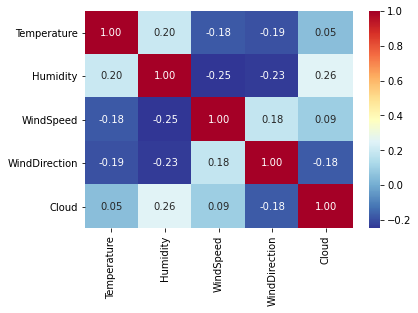

In [23]:
sns.heatmap(data = corr_data.corr(), annot=True, fmt = '.2f', cmap = 'RdYlBu_r')

In [22]:
# plt.figure(figsize=(15, 15))
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data = corr_data.corr(), annot=True, fmt = '.2f', cmap = 'RdYlBu_r',mask = mask)

ValueError: Mask must have the same shape as data.